In [2]:
# load data
import numpy as np
train_file = np.load('data/train.npz')
train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('data/test_input.npz')
test_data = test_file['data']
print("test_data's shape", test_data.shape)


train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
from joblib import Parallel, delayed
import os
import gc
import pickle
from pathlib import Path
from tqdm import tqdm

def rotate_trajectory(trajectory: np.ndarray, angle: float) -> np.ndarray:
    """
    Rotate trajectory by given angle around the origin.
    Updates position, velocity, and heading.
    
    Args:
        trajectory: Shape (timesteps, 6) where columns are [pos_x, pos_y, vel_x, vel_y, heading, obj_type]
        angle: Rotation angle in radians
        
    Returns:
        Rotated trajectory of same shape
    """
    if trajectory.shape[-1] < 6:
        raise ValueError("Trajectory must have 6 features")
        
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array([[cos_a, -sin_a],
                               [sin_a, cos_a]])
    
    rotated_trajectory = trajectory.copy()
    
    # Rotate positions (columns 0, 1)
    pos_xy = trajectory[:, :2]  # position_x, position_y
    rotated_pos = pos_xy @ rotation_matrix.T
    rotated_trajectory[:, :2] = rotated_pos
    
    # Rotate velocities (columns 2, 3)
    vel_xy = trajectory[:, 2:4]  # velocity_x, velocity_y
    rotated_vel = vel_xy @ rotation_matrix.T
    rotated_trajectory[:, 2:4] = rotated_vel
    
    # Update heading (column 4)
    rotated_trajectory[:, 4] = trajectory[:, 4] + angle
    
    # Keep object_type unchanged (column 5)
    
    return rotated_trajectory

def translate_trajectory(trajectory: np.ndarray, dx: float, dy: float) -> np.ndarray:
    """
    Translate trajectory by given offsets.
    Only affects position coordinates.
    
    Args:
        trajectory: Shape (timesteps, 6)
        dx: Translation in x direction
        dy: Translation in y direction
        
    Returns:
        Translated trajectory of same shape
    """
    if trajectory.shape[-1] < 6:
        raise ValueError("Trajectory must have 6 features")
        
    translated_trajectory = trajectory.copy()
    translated_trajectory[:, 0] += dx  # position_x
    translated_trajectory[:, 1] += dy  # position_y
    
    return translated_trajectory

def flip_horizontal(trajectory: np.ndarray) -> np.ndarray:
    """
    Flip trajectory horizontally (mirror across y-axis).
    Updates position, velocity, and heading.
    """
    if trajectory.shape[-1] < 6:
        raise ValueError("Trajectory must have 6 features")
        
    flipped = trajectory.copy()
    flipped[:, 0] = -flipped[:, 0]  # Negate position_x
    flipped[:, 2] = -flipped[:, 2]  # Negate velocity_x
    flipped[:, 4] = np.pi - flipped[:, 4]  # Mirror heading across y-axis
    
    return flipped

def flip_vertical(trajectory: np.ndarray) -> np.ndarray:
    """
    Flip trajectory vertically (mirror across x-axis).
    Updates position, velocity, and heading.
    """
    if trajectory.shape[-1] < 6:
        raise ValueError("Trajectory must have 6 features")
        
    flipped = trajectory.copy()
    flipped[:, 1] = -flipped[:, 1]  # Negate position_y
    flipped[:, 3] = -flipped[:, 3]  # Negate velocity_y
    flipped[:, 4] = -flipped[:, 4]  # Mirror heading across x-axis
    
    return flipped

def augment_single_sample(sample: np.ndarray, 
                         rotation_range: float = np.pi/4,
                         translation_range: float = 5.0,
                         flip_prob: float = 0.5) -> np.ndarray:
    """
    Apply random augmentations to a single sample.
    
    Args:
        sample: Shape (agents, timesteps, 6) for single scene
        rotation_range: Maximum rotation angle in radians
        translation_range: Maximum translation distance
        flip_prob: Probability of applying flips
        
    Returns:
        Augmented sample of same shape
    """
    if len(sample.shape) != 3 or sample.shape[2] != 6:
        raise ValueError(f"Expected shape (agents, timesteps, 6), got {sample.shape}")
    
    augmented = sample.copy()
    
    # Random rotation, translation parameters (same for all agents in scene)
    angle = np.random.uniform(-rotation_range, rotation_range)
    dx = np.random.uniform(-translation_range, translation_range)
    dy = np.random.uniform(-translation_range, translation_range)
    
    # Random flip decisions (same for all agents in scene)
    do_horizontal_flip = np.random.random() < flip_prob
    do_vertical_flip = np.random.random() < flip_prob
    
    for agent_idx in range(sample.shape[0]):
        trajectory = sample[agent_idx, :, :]  # Shape (timesteps, 6)
        
        # Skip if trajectory is all zeros (padding/inactive agent)
        if np.all(trajectory[:, :2] == 0):  # Check if positions are all zero
            continue
            
        # Apply transformations
        trajectory = rotate_trajectory(trajectory, angle)
        trajectory = translate_trajectory(trajectory, dx, dy)
        
        if do_horizontal_flip:
            trajectory = flip_horizontal(trajectory)
        
        if do_vertical_flip:
            trajectory = flip_vertical(trajectory)
            
        augmented[agent_idx, :, :] = trajectory
    
    return augmented

def augment_batch_worker(batch_data: np.ndarray,
                        rotation_range: float,
                        translation_range: float,
                        flip_prob: float) -> np.ndarray:
    """Process a batch of samples for parallel augmentation."""
    return np.array([augment_single_sample(sample,
                                          rotation_range,
                                          translation_range,
                                          flip_prob)
                     for sample in batch_data])

def augment_dataset(data: np.ndarray, 
                   num_augmentations: int = 5,
                   rotation_range: float = np.pi/4,
                   translation_range: float = 5.0,
                   flip_prob: float = 0.5,
                   return_original: bool = True,
                   n_jobs: Optional[int] = None,
                   batch_size: Optional[int] = None) -> np.ndarray:
    """
    Augment entire dataset.
    
    Args:
        data: Shape (scenes, agents, timesteps, 6) dataset
        num_augmentations: Number of augmented versions per sample
        rotation_range: Maximum rotation angle in radians
        translation_range: Maximum translation distance
        flip_prob: Probability of applying flips
        return_original: Whether to include original data in output
        n_jobs: Number of parallel jobs
        batch_size: Size of batches for parallel processing
        
    Returns:
        Augmented dataset with shape (scenes*(1+num_augmentations), agents, timesteps, 6)
    """
    if len(data.shape) != 4 or data.shape[3] != 6:
        raise ValueError(f"Expected shape (scenes, agents, timesteps, 6), got {data.shape}")
    
    original_size = data.shape[0]
    augmented_samples = []
    
    if return_original:
        augmented_samples.append(data)

    if n_jobs is None:
        n_jobs = min(os.cpu_count(), 8)
    elif n_jobs == -1:
        n_jobs = os.cpu_count()

    if batch_size is None:
        batch_size = max(1, original_size // n_jobs)

    print(f"Using {n_jobs} jobs with batch size {batch_size}")
    
    for aug_idx in tqdm(range(num_augmentations), desc="Augmentations"):
        batches = [data[i:i + batch_size] for i in range(0, original_size, batch_size)]

        augmented_batches = Parallel(n_jobs=n_jobs)(
            delayed(augment_batch_worker)(
                batch,
                rotation_range,
                translation_range,
                flip_prob
            ) for batch in tqdm(batches, desc=f"Processing aug {aug_idx + 1}", leave=False)
        )

        augmented_batch = np.concatenate(augmented_batches, axis=0)
        augmented_samples.append(augmented_batch)

    return np.concatenate(augmented_samples, axis=0)

def visualize_augmentations(original_sample: np.ndarray, 
                           num_examples: int = 4,
                           agent_idx: int = 0) -> None:
    """
    Visualize original and augmented trajectories for comparison.
    
    Args:
        original_sample: Single sample of shape (agents, timesteps, 6)
        num_examples: Number of augmented examples to show
        agent_idx: Which agent's trajectory to visualize
    """
    if len(original_sample.shape) != 3 or original_sample.shape[2] != 6:
        raise ValueError(f"Expected shape (agents, timesteps, 6), got {original_sample.shape}")
    
    if agent_idx >= original_sample.shape[0]:
        raise ValueError(f"agent_idx {agent_idx} >= number of agents {original_sample.shape[0]}")
    
    fig, axes = plt.subplots(1, num_examples + 1, figsize=(15, 3))
    
    # Extract original trajectory (position_x, position_y)
    orig_traj = original_sample[agent_idx, :, :2]  # Shape (timesteps, 2)
    
    # Plot original
    axes[0].plot(orig_traj[:, 0], orig_traj[:, 1], 'b-o', markersize=3)
    axes[0].set_title('Original')
    axes[0].grid(True)
    axes[0].axis('equal')
    
    # Plot augmented versions
    for i in range(num_examples):
        aug_sample = augment_single_sample(original_sample)
        aug_traj = aug_sample[agent_idx, :, :2]  # Shape (timesteps, 2)
        
        axes[i + 1].plot(aug_traj[:, 0], aug_traj[:, 1], 'r-o', markersize=3)
        axes[i + 1].set_title(f'Augmented {i + 1}')
        axes[i + 1].grid(True)
        axes[i + 1].axis('equal')
    
    plt.tight_layout()
    plt.show()


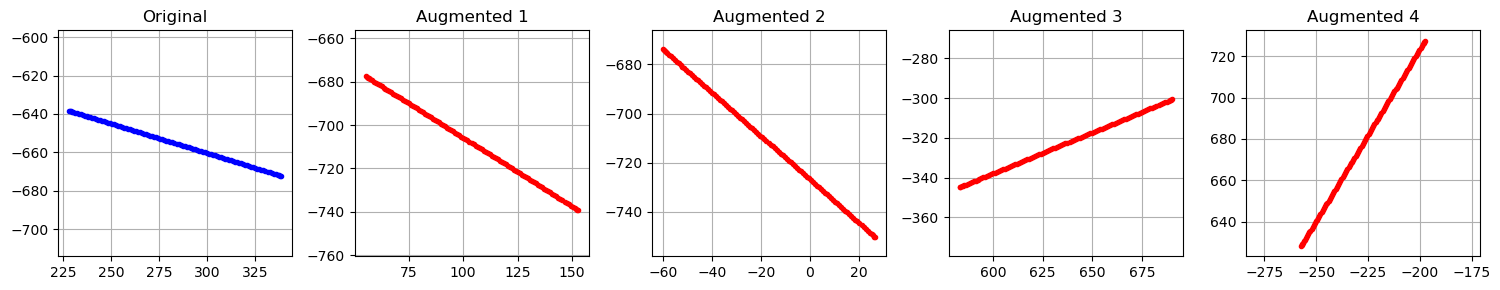

In [4]:
visualize_augmentations(train_data[0], agent_idx=0)

In [4]:
def standardize_data_dimensions(scenario_data):
    """
    Standardize position data by centering a single scenario at the origin.
    
    :param scenario_data: numpy array of shape (50, 110, 6)
                         where dimensions are [position_x, position_y, velocity_x, velocity_y, heading, object_type]
    :returns: tuple of (standardized_data, min_values)
             - standardized_data: same shape as input with centered positions
             - min_values: array of shape (2,) containing [min_x, min_y] for this scenario
    """
    # Copy the data to avoid modifying the original
    standardized_data = scenario_data.copy()
    
    # Extract position data (first 2 dimensions)
    positions = scenario_data[:, :, :2]  # Shape: (50, 110, 2)
    
    # Create mask for non-zero positions (to ignore padding)
    # We consider a position valid if it's not (0,0) or if the object_type is not 0
    object_types = scenario_data[:, :, 5]  # Shape: (50, 110)
    valid_mask = (positions[:, :, 0] != 0) | (positions[:, :, 1] != 0) | (object_types != 0)
    
    # Find min values across all valid positions in this scenario
    if np.any(valid_mask):
        valid_positions = positions[valid_mask]  # Shape: (num_valid_points, 2)
        min_x = np.min(valid_positions[:, 0])
        min_y = np.min(valid_positions[:, 1])
    else:
        # If no valid positions found, use 0 as min values
        min_x = 0
        min_y = 0
    
    # Store min values
    min_values = np.array([min_x, min_y])
    
    # Standardize positions by subtracting min values
    # Only modify non-zero positions to preserve padding
    for agent_idx in range(scenario_data.shape[0]):
        for time_idx in range(scenario_data.shape[1]):
            if valid_mask[agent_idx, time_idx]:
                standardized_data[agent_idx, time_idx, 0] -= min_x  # position_x
                standardized_data[agent_idx, time_idx, 1] -= min_y  # position_y
    
    return standardized_data, min_values


def denormalize_predictions(predictions, min_values):
    """
    Helper function to add back the min values to predicted positions.
    
    :param predictions: predicted data with standardized positions, shape (50, 110, 6) or similar
    :param min_values: array of shape (2,) containing [min_x, min_y] for this scenario
    :returns: predictions with original coordinate system restored
    """
    denormalized = predictions.copy()
    
    # Add back the min values to restore original coordinate system
    # Assuming predictions have position_x and position_y as first two dimensions
    denormalized[:, :, 0] += min_values[0]  # position_x
    denormalized[:, :, 1] += min_values[1]  # position_y
    
    return denormalized

In [5]:
def standardize_data_dimensions(scenario_data):
    """
    Standardize position data by centering a single scenario at the origin.
    
    :param scenario_data: numpy array of shape (50, 110, 6)
                         where dimensions are [position_x, position_y, velocity_x, velocity_y, heading, object_type]
    :returns: tuple of (standardized_data, min_values)
             - standardized_data: same shape as input with centered positions
             - min_values: array of shape (2,) containing [min_x, min_y] for this scenario
    """
    # Copy the data to avoid modifying the original
    standardized_data = scenario_data.copy()
    
    # Extract position data (first 2 dimensions)
    positions = scenario_data[:, :, :2]  # Shape: (50, 110, 2)
    
    # Create mask for non-zero positions (to ignore padding)
    # We consider a position valid if it's not (0,0) or if the object_type is not 0
    object_types = scenario_data[:, :, 5]  # Shape: (50, 110)
    valid_mask = (positions[:, :, 0] != 0) | (positions[:, :, 1] != 0) | (object_types != 0)
    
    # Find min values across all valid positions in this scenario
    if np.any(valid_mask):
        valid_positions = positions[valid_mask]  # Shape: (num_valid_points, 2)
        min_x = np.min(valid_positions[:, 0])
        min_y = np.min(valid_positions[:, 1])
    else:
        # If no valid positions found, use 0 as min values
        min_x = 0
        min_y = 0
    
    # Store min values
    min_values = np.array([min_x, min_y])
    
    # Standardize positions by subtracting min values
    # Only modify non-zero positions to preserve padding
    for agent_idx in range(scenario_data.shape[0]):
        for time_idx in range(scenario_data.shape[1]):
            if valid_mask[agent_idx, time_idx]:
                standardized_data[agent_idx, time_idx, 0] -= min_x  # position_x
                standardized_data[agent_idx, time_idx, 1] -= min_y  # position_y
    
    return standardized_data, min_values


def denormalize_predictions(predictions, min_values):
    """
    Helper function to add back the min values to predicted positions.
    
    :param predictions: predicted data with standardized positions, shape (50, 110, 6) or similar
    :param min_values: array of shape (2,) containing [min_x, min_y] for this scenario
    :returns: predictions with original coordinate system restored
    """
    denormalized = predictions.copy()
    
    # Add back the min values to restore original coordinate system
    # Assuming predictions have position_x and position_y as first two dimensions
    denormalized[:, :, 0] += min_values[0]  # position_x
    denormalized[:, :, 1] += min_values[1]  # position_y
    
    return denormalized

In [6]:
import numpy as np
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm

def standardize_single_scene(scene_data):
    """
    Wrapper function to standardize a single scene and return both standardized data and min values.
    This function will be called in parallel.
    """
    standardized_scene, min_vals = standardize_data_dimensions(scene_data)
    return standardized_scene, min_vals

def parallel_standardize_training_data(train_data, n_jobs=-1, verbose=True):
    """
    Parallelize the standardization of training data across all scenes.
    
    :param train_data: numpy array of shape (10000, 50, 110, 6)
    :param n_jobs: number of parallel jobs (-1 uses all available cores)
    :param verbose: whether to show progress bar
    :returns: tuple of (standardized_data, min_values_array)
    """
    print(f"Standardizing {train_data.shape[0]} scenes using {multiprocessing.cpu_count() if n_jobs == -1 else n_jobs} cores...")
    
    # Use joblib to parallelize the processing
    if verbose:
        # With progress bar
        results = Parallel(n_jobs=n_jobs)(
            delayed(standardize_single_scene)(train_data[i]) 
            for i in tqdm(range(train_data.shape[0]), desc="Processing scenes")
        )
    else:
        # Without progress bar
        results = Parallel(n_jobs=n_jobs)(
            delayed(standardize_single_scene)(train_data[i]) 
            for i in range(train_data.shape[0])
        )
    
    # Unpack results
    standardized_scenes, min_values_list = zip(*results)
    
    # Convert to numpy arrays
    standardized_data = np.array(standardized_scenes)
    min_values_array = np.array(min_values_list)
    
    print(f"Standardization complete!")
    print(f"Standardized data shape: {standardized_data.shape}")
    print(f"Min values shape: {min_values_array.shape}")
    
    return standardized_data, min_values_array

In [7]:
train_data = train_data[:, :5, :, :]

In [ ]:
# full agents are too much data; only want 5 agents worth
train_data = train_data[:, :5, :, :]

In [8]:
# Main execution code
augmented_pkl_path = Path("augmented_train.pkl")

# Check if the file exists
if augmented_pkl_path.exists():
    print("Loading augmented data from pickle file...")
    with open(augmented_pkl_path, "rb") as f:
        augmented_train = pickle.load(f)
else:
    print("Augmented data not found. Running augmentation...")
    # Split into 5 chunks
    num_chunks = 5
    chunk_size = len(train_data) // num_chunks
    chunks = [train_data[i * chunk_size: (i + 1) * chunk_size] for i in range(num_chunks - 1)]
    chunks.append(train_data[(num_chunks - 1) * chunk_size:])  # last chunk
    
    augmented_chunks = []
    for i, chunk in enumerate(tqdm(chunks, desc="Processing chunks")):
        print(f"Augmenting chunk {i+1}/{num_chunks}...")
        augmented_chunk = augment_dataset(
            chunk, 
            num_augmentations=5,
            n_jobs=-1,
            batch_size=25
        )
        augmented_chunks.append(augmented_chunk)
        
        # Force cleanup
        del augmented_chunk
        del chunk
        gc.collect()
    
    # Concatenate all augmented chunks
    augmented_train = np.concatenate(augmented_chunks, axis=0)
    print("Augmentation done. Preparing to dump to pickle...")
    
    # Uncomment to save to pickle
    # with open(augmented_pkl_path, "wb") as f:
    #     pickle.dump(augmented_train, f)
    # print("Dumped to pickle.")

print(f"Original shape: {train_data.shape}")
print(f"Augmented shape: {augmented_train.shape}")

Augmented data not found. Running augmentation...


Processing chunks:   0%|          | 0/5 [00:00<?, ?it/s]

Augmenting chunk 1/5...
Using 40 jobs with batch size 25



Augmentations:   0%|          | 0/5 [00:00<?, ?it/s]

Processing aug 1:   0%|          | 0/80 [00:00<?, ?it/s]

Processing aug 1:  50%|█████     | 40/80 [00:01<00:01, 30.19it/s]

Processing aug 1: 100%|██████████| 80/80 [00:01<00:00, 61.01it/s]

                                                                 
Augmentations:  20%|██        | 1/5 [00:02<00:08,  2.24s/it]

Processing aug 2:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  40%|████      | 2/5 [00:02<00:03,  1.15s/it]

Processing aug 3:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  60%|██████    | 3/5 [00:03<00:01,  1.25it/s]

Processing aug 4:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  80%|████████  | 4/5 [00:03<00:00,  1.56it/s]

Processing aug 5:   0%|          | 0/80 [00:00<?, ?it/s]

                                    

Augmenting chunk 2/5...
Using 40 jobs with batch size 25



Augmentations:   0%|          | 0/5 [00:00<?, ?it/s]

Processing aug 1:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  20%|██        | 1/5 [00:00<00:01,  2.93it/s]

Processing aug 2:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  40%|████      | 2/5 [00:00<00:01,  2.72it/s]

Processing aug 3:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  60%|██████    | 3/5 [00:01<00:00,  2.77it/s]

Processing aug 4:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  80%|████████  | 4/5 [00:01<00:00,  2.80it/s]

Processing aug 5:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Processing chunks:  40%|████      | 2/5 [00:05<00:08,  2.79s/it]

Augmenting chunk 3/5...
Using 40 jobs with batch size 25



Augmentations:   0%|          | 0/5 [00:00<?, ?it/s]

Processing aug 1:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  20%|██        | 1/5 [00:00<00:01,  3.16it/s]

Processing aug 2:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  40%|████      | 2/5 [00:00<00:01,  2.97it/s]

Processing aug 3:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  60%|██████    | 3/5 [00:01<00:00,  2.87it/s]

Processing aug 4:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  80%|████████  | 4/5 [00:01<00:00,  2.71it/s]

Processing aug 5:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Processing chunks:  60%|██████    | 3/5 [00:07<00:04,  2.43s/it]

Augmenting chunk 4/5...
Using 40 jobs with batch size 25



Augmentations:   0%|          | 0/5 [00:00<?, ?it/s]

Processing aug 1:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  20%|██        | 1/5 [00:00<00:01,  2.09it/s]

Processing aug 2:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  40%|████      | 2/5 [00:00<00:01,  2.43it/s]

Processing aug 3:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  60%|██████    | 3/5 [00:01<00:00,  2.67it/s]

Processing aug 4:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  80%|████████  | 4/5 [00:01<00:00,  2.54it/s]

Processing aug 5:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Processing chunks:  80%|████████  | 4/5 [00:10<00:02,  2.32s/it]

Augmenting chunk 5/5...
Using 40 jobs with batch size 25



Augmentations:   0%|          | 0/5 [00:00<?, ?it/s]

Processing aug 1:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  20%|██        | 1/5 [00:00<00:01,  2.87it/s]

Processing aug 2:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  40%|████      | 2/5 [00:00<00:01,  2.81it/s]

Processing aug 3:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  60%|██████    | 3/5 [00:01<00:00,  2.83it/s]

Processing aug 4:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Augmentations:  80%|████████  | 4/5 [00:01<00:00,  2.89it/s]

Processing aug 5:   0%|          | 0/80 [00:00<?, ?it/s]

                                                        
Processing chunks: 100%|██████████| 5/5 [00:12<00:00,  2.40s/it]


Augmentation done. Preparing to dump to pickle...
Original shape: (10000, 5, 110, 6)
Augmented shape: (60000, 5, 110, 6)


In [9]:
standardized_train_data, min_values = parallel_standardize_training_data(
    augmented_train, 
    n_jobs=-1,  # Use all available cores
    verbose=True
)
standardized_train_data.shape

Standardizing 60000 scenes using 40 cores...


Processing scenes: 100%|██████████| 60000/60000 [00:11<00:00, 5384.82it/s]


Standardization complete!
Standardized data shape: (60000, 5, 110, 6)
Min values shape: (60000, 2)


(60000, 5, 110, 6)

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, RepeatVector, TimeDistributed, Dropout

2025-05-30 21:59:06.259398: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-30 21:59:06.259462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-30 21:59:06.261209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-30 21:59:06.271348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
import tensorflow as tf

def angle_change_loss(y_pred):
    """
    Penalize large changes in direction between consecutive deltas.

    Args:
        y_pred: Tensor of shape (batch_size, Tpred, 2)

    Returns:
        Scalar loss penalizing angle differences
    """
    # Normalize deltas to unit vectors
    delta_unit = tf.math.l2_normalize(y_pred, axis=-1)  # shape: (B, T, 2)

    # Compute cosine similarity between consecutive deltas
    dot_products = tf.reduce_sum(delta_unit[:, 1:, :] * delta_unit[:, :-1, :], axis=-1)  # shape: (B, T-1)

    # Clamp for numerical stability (to avoid NaNs in arccos)
    dot_products = tf.clip_by_value(dot_products, -1.0, 1.0)

    # Compute angle in radians between -1 and 1 (cos⁻¹)
    angle_diff = tf.acos(dot_products)  # shape: (B, T-1)

    # Mean angle difference per sequence
    return tf.reduce_mean(angle_diff)

def combined_loss(y_true, y_pred):
    # Check if there are NaN values in y_true or y_pred
    nan_check = tf.reduce_any(tf.math.is_nan(y_true)) | tf.reduce_any(tf.math.is_nan(y_pred))

    # Use tf.cond to perform the check
    def return_nan_loss():
        return tf.constant(float('nan'))

    def calculate_loss():
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        angle_loss = angle_change_loss(y_pred)
        return mse_loss + 0.5 * angle_loss

    return tf.cond(nan_check, return_nan_loss, calculate_loss)




In [12]:
def create_lstm_encoder_decoder(input_dim, output_dim, timesteps_in, timesteps_out, lstm_units=512, num_layers=3, loss_fn='mse', lr=0.001):
    inputs = Input(shape=(timesteps_in, input_dim))

    # Encoder
    x = inputs
    for _ in range(num_layers):
        x = LSTM(lstm_units, return_sequences=True)(x)
        # x = Dropout(0.2)(x)
    encoded = LSTM(lstm_units)(x)  # Final encoder output

    # Decoder
    x = RepeatVector(timesteps_out)(encoded)
    for _ in range(num_layers):
        x = LSTM(lstm_units, return_sequences=True)(x)
        # x = Dropout(0.2)(x)
    
    
    x = TimeDistributed(Dense(128, activation='relu'))(x)
    x = TimeDistributed(Dense(64, activation='relu'))(x)
    outputs = TimeDistributed(Dense(output_dim))(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae']) 

    # model.compile(optimizer=Adam(learning_rate=1e-5), loss=combined_loss) #switch loss back to 'mse' for older solution 
    return model

In [13]:
from keras.src.callbacks import LearningRateScheduler, EarlyStopping, Callback
from keras.src.optimizers import Adam
from keras import Model
import numpy as np


def exponential_decay_schedule(epoch, lr):
    decay_rate = 0.9
    decay_steps = 5
    if epoch % decay_steps == 0 and epoch:
        print('Learning rate update:', lr * decay_rate)
        return lr * decay_rate
    return lr


# Custom callback to monitor LR and stop training
class LRThresholdCallback(Callback):
    def __init__(self, threshold=9e-5):
        super().__init__()
        self.threshold = threshold
        self.should_stop = False

    def on_epoch_end(self, epoch, logs=None):
        lr = float(self.model.optimizer.learning_rate.numpy())
        if lr < self.threshold:
            print(f"\nLearning rate {lr:.6f} < threshold {self.threshold}, moving to Phase 2.")
            self.model.stop_training = True

def train_model(train_data, batch_size=32, validation_split=0.2, Tobs=50, Tpred=60):
    n_scenarios = train_data.shape[0]
    X_train_raw = []
    y_train_deltas = []

    for i in range(n_scenarios):
        ego_data = train_data[i, 0, :, :]
        if np.all(ego_data == 0):
            continue

        observed = ego_data[:Tobs]            # shape (50, 6)
        future = ego_data[Tobs:Tobs+Tpred, :2]
        last_obs_pos = observed[-1, :2]

        if np.any(np.all(observed == 0, axis=1)) or np.any(np.all(future == 0, axis=1)):
            continue

        # Compute deltas w.r.t. previous future timestep
        delta = np.diff(np.vstack([last_obs_pos, future]), axis=0)  # (60, 2)

        X_train_raw.append(observed)
        y_train_deltas.append(delta)
    

    X_train = np.array(X_train_raw)
    y_train = np.array(y_train_deltas)

    print(f"Training on {X_train.shape[0]} valid sequences.")
    print(f"Input shape: {X_train.shape}, Delta Output shape: {y_train.shape}")
    
    # --- Normalize Input and Output ---
    X_mean = X_train.mean(axis=(0, 1), keepdims=True)  # shape: (1, 1, 6)
    X_std = X_train.std(axis=(0, 1), keepdims=True) + 1e-8

    y_mean = y_train.mean(axis=(0, 1), keepdims=True)  # shape: (1, 1, 2)
    y_std = y_train.std(axis=(0, 1), keepdims=True) + 1e-8

    X_train = (X_train - X_mean) / X_std
    y_train = (y_train - y_mean) / y_std
    
    print(X_train[:2])
    print(y_train[:2])

    model = create_lstm_encoder_decoder(
        input_dim=X_train.shape[-1],
        output_dim=2,
        timesteps_in=Tobs,
        timesteps_out=Tpred,
        loss_fn='mse',
        lr=0.001
    )

    phase1_callbacks = [
        LearningRateScheduler(exponential_decay_schedule),
        EarlyStopping(patience=4, restore_best_weights=True, monitor='val_loss'),
        LRThresholdCallback(threshold=9e-5)
    ]

    print("\n--- Phase 1: Training ---")
    model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=phase1_callbacks,
        verbose=1
    )

    print("\n--- Phase 2: Fine-tuning ---")
    model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])
    phase2_callbacks = [
        LearningRateScheduler(exponential_decay_schedule),
        EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')
    ]
    model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=phase2_callbacks,
        verbose=1
    )

    # Return model and normalization parameters
    return model, X_mean, X_std, y_mean, y_std


In [14]:
import pickle

def save_model(model, filepath='lstm_1.pkl'):
    """Save model and scaler together in a pickle file"""
    model_json = model.to_json()
    model_weights = model.get_weights()
    data = {
        'model_json': model_json,
        'model_weights': model_weights,
    }
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)
    print(f"Model saved to {filepath}")

def load_model(filepath='lstm_1.pkl'):
    """Load model and scaler from pickle file"""
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    
    # Reconstruct model
    model = tf.keras.models.model_from_json(data['model_json'])
    model.set_weights(data['model_weights'])
    model.compile(optimizer='adam', loss='mse')
    
    return model

In [16]:
# first check that the model can overfit on small data
# model, X_mean, X_std, y_mean, y_std  = train_model(train_data[:20], batch_size=20, validation_split=0)

In [17]:
def plot_mae_by_timestep(y_true, y_pred):
    """
    Visualize MAE across timesteps in the prediction horizon.
    
    Args:
        y_true (np.ndarray): shape (N, Tpred, 2)
        y_pred (np.ndarray): shape (N, Tpred, 2)
    """
    mae_per_timestep = np.mean(np.abs(y_true - y_pred), axis=(0, 2))  # shape (Tpred,)
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.plot(mae_per_timestep, label='MAE per Timestep')
    plt.xlabel('Timestep')
    plt.ylabel('MAE (meters)')
    plt.title('Mean Absolute Error Over Prediction Horizon')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [18]:
def reconstruct_absolute_positions(pred_deltas, last_observed_positions):
    """
    Reconstruct absolute predicted positions by adding deltas to the last observed position.

    Args:
        pred_deltas: np.ndarray of shape (N, Tpred, 2)
        last_observed_positions: np.ndarray of shape (N, 2)

    Returns:
        np.ndarray of shape (N, Tpred, 2)
    """
    return last_observed_positions[:, None, :] + np.cumsum(pred_deltas, axis=1)



def forecast_positions(scenario_data, Tobs, Tpred, model, X_mean, X_std, y_mean, y_std):
    """
    Use normalized LSTM model to forecast future deltas and reconstruct absolute positions.

    Args:
        scenario_data (numpy.ndarray): Shape (agents, time_steps, dimensions)
        Tobs (int): Number of observed time steps
        Tpred (int): Number of future time steps to predict
        model (Model): Trained LSTM model that predicts normalized deltas
        X_mean, X_std: Normalization stats for input
        y_mean, y_std: Normalization stats for output

    Returns:
        numpy.ndarray: Predicted absolute positions of shape (agents, Tpred, 2)
    """
    agents, _, _ = scenario_data.shape
    predicted_positions = np.zeros((agents, Tpred, 2))
    pred_deltas_all = []

    for agent_idx in range(agents):
        agent_data = scenario_data[agent_idx, :Tobs, :]  # shape (Tobs, 6)

        # Skip if fully padded
        if np.all(agent_data == 0):
            continue

        # Normalize input
        X_pred = np.expand_dims(agent_data, axis=0)  # shape (1, Tobs, 6)
        X_pred_norm = (X_pred - X_mean) / X_std

        # Predict normalized deltas
        pred_deltas_norm = model.predict(X_pred_norm, verbose=0)  # shape (1, Tpred, 2)

        # Denormalize deltas
        pred_deltas = pred_deltas_norm * y_std + y_mean
        pred_deltas_all.append(pred_deltas[0])

        # Reconstruct absolute positions
        last_pos = agent_data[Tobs - 1, :2]  # shape (2,)
        abs_positions = reconstruct_absolute_positions(
            pred_deltas=pred_deltas,
            last_observed_positions=np.expand_dims(last_pos, axis=0)
        )[0]

        predicted_positions[agent_idx] = abs_positions

    return predicted_positions


In [19]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def make_gif(data_matrix1, data_matrix2, name='comparison'):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation

    cmap1 = plt.cm.get_cmap('viridis', 50)
    cmap2 = plt.cm.get_cmap('plasma', 50)

    assert data_matrix1.shape[1] == data_matrix2.shape[1], "Both matrices must have same number of timesteps"
    timesteps = data_matrix1.shape[1]

    fig, axes = plt.subplots(1, 2, figsize=(18, 9))
    ax1, ax2 = axes

    def update(frame):
        for ax in axes:
            ax.clear()

        for i in range(data_matrix1.shape[0]):
            for (data_matrix, ax, cmap) in [(data_matrix1, ax1, cmap1), (data_matrix2, ax2, cmap2)]:
                x = data_matrix[i, frame, 0]
                y = data_matrix[i, frame, 1]
                if x != 0 and y != 0:
                    xs = data_matrix[i, :frame+1, 0]
                    ys = data_matrix[i, :frame+1, 1]
                    mask = (xs != 0) & (ys != 0)
                    xs = xs[mask]
                    ys = ys[mask]
                    if len(xs) > 0 and len(ys) > 0:
                        color = cmap(i)
                        ax.plot(xs, ys, alpha=0.9, color=color)
                        ax.scatter(x, y, s=80, color=color)

        # Plot ego vehicle (index 0) on both
        ax1.plot(data_matrix1[0, :frame, 0], data_matrix1[0, :frame, 1], color='tab:orange', label='Ego Vehicle')
        ax1.scatter(data_matrix1[0, frame, 0], data_matrix1[0, frame, 1], s=80, color='tab:orange')
        ax1.set_title('Prediction')

        ax2.plot(data_matrix2[0, :frame, 0], data_matrix2[0, :frame, 1], color='tab:orange', label='Ego Vehicle')
        ax2.scatter(data_matrix2[0, frame, 0], data_matrix2[0, frame, 1], s=80, color='tab:orange')
        ax2.set_title('Actual')

        for ax, data_matrix in zip(axes, [data_matrix1, data_matrix2]):
            ax.set_xlim(data_matrix[:, :, 0][data_matrix[:, :, 0] != 0].min() - 10,
                        data_matrix[:, :, 0][data_matrix[:, :, 0] != 0].max() + 10)
            ax.set_ylim(data_matrix[:, :, 1][data_matrix[:, :, 1] != 0].min() - 10,
                        data_matrix[:, :, 1][data_matrix[:, :, 1] != 0].max() + 10)
            ax.legend()
            ax.set_xlabel('X')
            ax.set_ylabel('Y')

        # Compute MSE over non-zero entries up to current frame
        mask = (data_matrix2[:, :frame+1, :] != 0) & (data_matrix1[:, :frame+1, :] != 0)
        mse = np.mean((data_matrix1[:, :frame+1, :][mask] - data_matrix2[:, :frame+1, :][mask]) ** 2)

        fig.suptitle(f"Timestep {frame} - MSE: {mse:.4f}", fontsize=16)
        return ax1.collections + ax1.lines + ax2.collections + ax2.lines

    anim = animation.FuncAnimation(fig, update, frames=list(range(0, timesteps, 3)), interval=100, blit=True)
    anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
    plt.close()


In [13]:
# visualize prediction

# model = load_model()

# Parameters
Tobs = 50
Tpred = 60

data = train_data[5000]

# Select a test scenario (can use any valid index)
test_scenario = data.copy()  # shape (agents, time_steps, features)

# Forecast future positions
predicted_positions = forecast_positions(test_scenario, Tobs, Tpred, model, X_mean, X_std, y_mean, y_std)

# Create combined matrix of past observed + predicted for ego agent (agent 0)
ego_past = test_scenario[0, :Tobs, :2]               # shape (Tobs, 2)
ego_future = predicted_positions[0]                  # shape (Tpred, 2)
ego_full = np.concatenate([ego_past, ego_future], axis=0)  # shape (Tobs + Tpred, 2)

# Create updated scenario with predicted ego and original others
updated_scenario = test_scenario.copy()
updated_scenario[0, :Tobs+Tpred, :2] = ego_full  # Replace ego trajectory

# Visualize
make_gif(updated_scenario, data, name='lstm1')


/tmp/ipykernel_958706/849000278.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1 = plt.cm.get_cmap('viridis', 50)
/tmp/ipykernel_958706/849000278.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = plt.cm.get_cmap('plasma', 50)


In [20]:
# Train the model
model, X_mean, X_std, y_mean, y_std = train_model(standardized_train_data)

# Save the model 
save_model(model)

Training on 59177 valid sequences.
Input shape: (59177, 50, 6), Delta Output shape: (59177, 60, 2)
[[[-0.13970156 -0.24849051 -1.02788938  0.32343215  1.02491015
    0.        ]
  [-0.14015124 -0.24827328 -1.02788938  0.32343215  1.02486038
    0.        ]
  [-0.14070611 -0.24800505 -2.05106962  0.66404411  1.02479781
    0.        ]
  [-0.14136238 -0.24768753 -2.03929605  0.6638565   1.02472513
    0.        ]
  [-0.14211274 -0.24732411 -2.03699826  0.66559847  1.02464859
    0.        ]
  [-0.14294496 -0.24692063 -2.04646197  0.66753463  1.02457093
    0.        ]
  [-0.1438432  -0.24648478 -2.02514729  0.6604432   1.02448983
    0.        ]
  [-0.14478756 -0.24602615 -2.02626388  0.66091089  1.02440815
    0.        ]
  [-0.14575411 -0.24555641 -2.04854177  0.66841902  1.02432519
    0.        ]
  [-0.14671496 -0.2450891  -2.03612317  0.66681081  1.02424241
    0.        ]
  [-0.14763835 -0.24463947 -2.02383453  0.66521943  1.02417101
    0.        ]
  [-0.14853453 -0.24420263 -2.04

In [21]:
from sklearn.metrics import mean_squared_error


def evaluate_mse(train_data, model, Tobs=50, Tpred=60):
    """
    Computes LSTM prediction for ego agent and evaluates MSE with progress reporting.
    """
    N = train_data.shape[0]
    mse_list = []
    valid_scenarios = 0
    
    print(f"Evaluating {N} scenarios...")
    
    # Progress reporting variables
    report_interval = max(1, N // 10)  # Report at 10% intervals
    
    for i in range(N):
        # Progress reporting
        if i % report_interval == 0 or i == N-1:
            print(f"Processing scenario {i+1}/{N} ({(i+1)/N*100:.1f}%)")
        
        scenario_data = train_data[i]
        ego_agent_data = scenario_data[0]
        ground_truth = ego_agent_data[Tobs:Tobs+Tpred, :2]
        
        # Skip if ground truth contains all zeros (padded)
        if np.all(ground_truth == 0):
            continue
            
        valid_scenarios += 1
        
        # Forecast future positions
        predicted_positions = forecast_positions(
            ego_agent_data[np.newaxis, :, :],
            Tobs, Tpred, model, X_mean, X_std, y_mean, y_std
        )
        
        # Compute MSE
        mse = mean_squared_error(ground_truth, predicted_positions[0])
        mse_list.append(mse)
        
        # Occasional MSE reporting
        if i % report_interval == 0:
            print(f"  Current scenario MSE: {mse:.4f}")
    
    # Final results
    if mse_list:
        overall_mse = np.mean(mse_list)
        print(f"Evaluation complete: {valid_scenarios} valid scenarios")
        print(f"Mean Squared Error (MSE): {overall_mse:.4f}")
        print(f"Min MSE: {np.min(mse_list):.4f}, Max MSE: {np.max(mse_list):.4f}")
        return overall_mse
    else:
        print("No valid scenarios for evaluation.")
        return None

In [24]:
# Evaluate on training data
evaluate_mse(standardized_train_data[3234:5300], model)

Evaluating 2066 scenarios...
Processing scenario 1/2066 (0.0%)
  Current scenario MSE: 4.6116
Processing scenario 207/2066 (10.0%)
  Current scenario MSE: 0.4051
Processing scenario 413/2066 (20.0%)
  Current scenario MSE: 9.9705
Processing scenario 619/2066 (30.0%)
  Current scenario MSE: 2.7963
Processing scenario 825/2066 (39.9%)
  Current scenario MSE: 0.1236
Processing scenario 1031/2066 (49.9%)
  Current scenario MSE: 0.3290
Processing scenario 1237/2066 (59.9%)
  Current scenario MSE: 26.2397
Processing scenario 1443/2066 (69.8%)
  Current scenario MSE: 4.0677
Processing scenario 1649/2066 (79.8%)
  Current scenario MSE: 9.9667
Processing scenario 1855/2066 (89.8%)
  Current scenario MSE: 1.8468
Processing scenario 2061/2066 (99.8%)
  Current scenario MSE: 2.7505
Processing scenario 2066/2066 (100.0%)
Evaluation complete: 2066 valid scenarios
Mean Squared Error (MSE): 6.5405
Min MSE: 0.0002, Max MSE: 132.5785


6.5404825890229645

In [25]:
import pandas as pd
import numpy as np

def generate_submission(data, output_csv, Tobs=50, Tpred=60):
    """
    Applies forecasting and generates a submission CSV with format:
    index,x,y where index is auto-generated and matches submission key.
    
    Args:
        data (np.ndarray): Test data of shape (num_scenarios, 50, 50, 6).
        output_csv (str): Output CSV file path.
        Tobs (int): Observed time steps (default 50).
        Tpred (int): Prediction time steps (default 60).
    """

    predictions = []

    for i in range(data.shape[0]):
        scenario_data = data[i]            # Shape: (50, 50, 6)
        
        # Step 1: Standardize the scene data
        standardized_scenario, min_values = standardize_data_dimensions(scenario_data)
        
        # Extract ego agent data from standardized scenario
        ego_agent_data = standardized_scenario[0]  # Shape: (50, 6)

        # Step 2: Predict future positions for the ego agent using standardized data
        predicted_positions = forecast_positions(
            ego_agent_data[np.newaxis, :, :], Tobs, Tpred, model, X_mean, X_std, y_mean, y_std
        )  # Shape: (1, 60, 2)

        # Step 3: Denormalize the predictions to restore original coordinate system
        # Create a dummy array with the same structure as the standardized data for denormalization
        # We only need to denormalize the x,y positions (first 2 columns)
        dummy_predictions = np.zeros((1, Tpred, 6))  # Shape: (1, 60, 6)
        dummy_predictions[0, :, :2] = predicted_positions[0]  # Insert predicted x,y positions
        
        # Denormalize the predictions
        denormalized_predictions = denormalize_predictions(dummy_predictions, min_values)
        
        # Extract only the x,y positions from denormalized predictions
        final_positions = denormalized_predictions[0, :, :2]  # Shape: (60, 2)

        # Append 60 predictions (x, y) for this scenario
        predictions.extend(final_positions)  # Shape: (60, 2)

    # Create DataFrame without explicit ID
    submission_df = pd.DataFrame(predictions, columns=["x", "y"])
    submission_df.index.name = 'index'  # Match Kaggle format

    # Save CSV with index
    submission_df.to_csv(output_csv)
    print(f"Submission file '{output_csv}' saved with shape {submission_df.shape}")

# Generate submission with standardization
generate_submission(test_data, 'lstm_submission.csv')

Submission file 'lstm_submission.csv' saved with shape (126000, 2)
